In [ ]:
# !wget http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar

In [ ]:
# ! tar -xf indoorCVPR_09.tar

In [ ]:
# ! pip install kaggle

In [ ]:
# ! mkdir ~/.kaggle

In [ ]:
# ! cp kaggle.json ~/.kaggle/

In [ ]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets download gpiosenka/100-bird-species

In [ ]:
# ! unzip 100-bird-species.zip

In [ ]:
# # using github url
# ! pip install git+https://github.com/zhanghang1989/ResNeSt

In [ ]:
# # using pypi
# ! pip install resnest --pre

In [ ]:
# ! pip install split-folders

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from PIL import Image, ImageFile
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time
import os
import copy
from resnest.torch import resnest50
import splitfolders

In [ ]:
# splitfolders.ratio("Images", output="output",
#     seed=1, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [ ]:
torch.manual_seed(1)
np.random.seed(1)

In [ ]:
num_classes = 400
N_worker = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_model_path = 'resnest50_bird.pth'
save_path = 'resnest50_bird.pth'
data_dir = '/content'
test_dir = '/content/test'
test_name_label_pair_path = './test_name_label.txt'

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            if phase == "valid":
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            # keep track the best validation accuracy and save its weight
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [ ]:
# freeze the layers where the pre-trained weights get loaded
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(num_classes=num_classes, feature_extract=True, model_name='resnest50', use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == 'resnest50':
        model_ft = resnest50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    model_ft = model_ft.to(device)
    params_to_update = model_ft.parameters()
    optimizer_ft = optim.Adam(params_to_update, lr=0.001)

    return model_ft, optimizer_ft, input_size

In [ ]:
def train():
    num_epochs = 10
    batch_size = 64
    print('Train...')
    model_ft, optimizer_ft, input_size = initialize_model()
    criterion = nn.CrossEntropyLoss()
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    # read images into dataloaders
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True,
                                        num_workers=N_worker) for x in ['train', 'valid']}
    print("train total size: " + str(len(image_datasets["train"])))
    print("val total size: " + str(len(image_datasets["valid"])))

    model_ft, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model_ft, dataloaders_dict, 
                                                                                                     criterion, optimizer_ft, num_epochs)
    
    torch.save(model_ft.state_dict(), save_path)
    print('model saved.')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [ ]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train()

Train...


Downloading: "https://github.com/zhanghang1989/ResNeSt/releases/download/weights_step1/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

train total size: 58388
val total size: 2000
Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.5576 Acc: 0.7172
valid Loss: 0.4260 Acc: 0.9180
Epoch 1/9
----------
train Loss: 0.3699 Acc: 0.9276
valid Loss: 0.3001 Acc: 0.9375
Epoch 2/9
----------
train Loss: 0.1993 Acc: 0.9637
valid Loss: 0.2524 Acc: 0.9380
Epoch 3/9
----------
train Loss: 0.1203 Acc: 0.9807
valid Loss: 0.2044 Acc: 0.9515
Epoch 4/9
----------
train Loss: 0.0806 Acc: 0.9874
valid Loss: 0.2166 Acc: 0.9435
Epoch 5/9
----------
train Loss: 0.0607 Acc: 0.9902
valid Loss: 0.2005 Acc: 0.9455
Epoch 6/9
----------
train Loss: 0.0450 Acc: 0.9932
valid Loss: 0.2039 Acc: 0.9460
Epoch 7/9
----------
train Loss: 0.0369 Acc: 0.9942
valid Loss: 0.2063 Acc: 0.9470
Epoch 8/9
----------
train Loss: 0.0310 Acc: 0.9947
valid Loss: 0.1986 Acc: 0.9485
Epoch 9/9
----------
train Loss: 0.0267 Acc: 0.9952
valid Loss: 0.1883 Acc: 0.9520
Training complete in 64m 37s
Best val Acc: 0.952000
model saved.


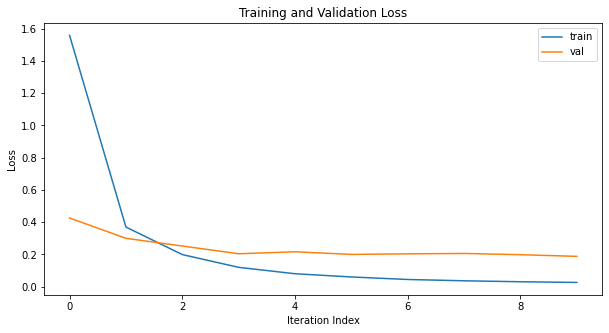

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("Iteration Index")
plt.ylabel("Loss")
plt.legend()
plt.show()

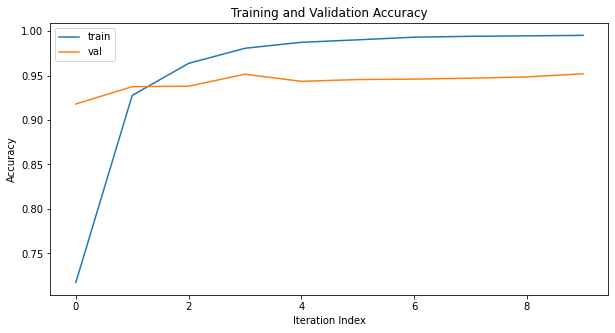

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot([acc_tensor.item() for acc_tensor in train_acc_history], label="train")
plt.plot([acc_tensor.item() for acc_tensor in val_acc_history], label="val")
plt.xlabel("Iteration Index")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(train_loss_history)
print(val_loss_history)
print([acc_tensor.item() for acc_tensor in train_acc_history])
print([acc_tensor.item() for acc_tensor in val_acc_history])

[1.5575953271606733, 0.3699479692489176, 0.19932783217987737, 0.12034562833935396, 0.08061100790302517, 0.060662809750956524, 0.045036364406716815, 0.03693410278085307, 0.03101962101462974, 0.026692055914041366]
[0.4260015025138855, 0.30010572576522826, 0.2524019968509674, 0.2044382429420948, 0.21657599091529847, 0.2004966599866748, 0.2039409680068493, 0.20634008514881133, 0.1985650986433029, 0.18830640554428102]
[0.7172192916352675, 0.9275878605192848, 0.9637082962252518, 0.9806809618414744, 0.9874117969445777, 0.9902034664657121, 0.993183530862506, 0.9941597588545592, 0.9946735630609029, 0.9952387476878811]
[0.918, 0.9375, 0.9380000000000001, 0.9515, 0.9435, 0.9455, 0.9460000000000001, 0.9470000000000001, 0.9485, 0.9520000000000001]


In [ ]:
# load the saved model for prediction
model_ft = resnest50(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft.load_state_dict(torch.load(load_model_path))
model_ft = model_ft.to(device)

In [ ]:
def predict(model, dataloader):
    model.eval()

    running_corrects = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloader.dataset)
    print('Acc: {:.4f}'.format(acc))

In [ ]:
# read images into dataloader
test_imageFolder = datasets.ImageFolder(os.path.join(data_dir, "test"), 
        transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))
print("test total size: " + str(len(test_imageFolder)))
test_loader = torch.utils.data.DataLoader(test_imageFolder, batch_size=64, shuffle=True, num_workers=N_worker)

test total size: 2000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
predict(model_ft, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Acc: 0.9540
